# Find Dumping Offers

## Observations:
- For the same model, pvp varies (depending on configuration I guess)
- Average difference between pvp and cash-price varies among brand and model
- Some brands are underrepresanted, like Audi (only 2 samples)

## Actions:
- Taking the ratio (pvp-cashprice)/pvp = dump_value instead of only difference for normalizing. This value is between 0 and 1
- Calculate z-score per brand and per model
- Discarding brands that made less than 10 offers

## Load Packages

In [3]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # Plotting
import numpy as np
import re # regular expressions --> Finding Postal Code
#from datetime import datetime

## Read Data

In [2]:
data = pd.read_csv('Dumping.csv', delimiter = ',', skiprows=0, squeeze=False, skip_blank_lines=True, index_col=None)
#data

## Discard brands with less than 10 offers

In [4]:
def brandNumber(brand):
    return brand, len(data[data.brand==brand])

In [6]:
# Get all unique brands and models
brand_names = np.unique(np.asarray(data.brand[:]))
model_names = np.unique(np.asarray(data.model[:]))

In [27]:
# discard brands with less than 10 offers
print 'Before Dropping: {} entries'.format(len(data))
brandNumbers = map(brandNumber, brand_names)
for nr in brandNumbers:
    if nr[1] <= 10:
        data = data[data.brand != nr[0]]
        print '{} dropped'.format(nr[0])
print 'After Dropping: {} entries'.format(len(data))
brand_names = np.unique(np.asarray(data.brand[:]))
model_names = np.unique(np.asarray(data.model[:]))

Before Dropping: 155609 entries
Audi dropped
Volkswagen dropped
After Dropping: 155609 entries


## Calculate mean and std of dump-value (pvp-cashprize/pvp) per model and brand

In [16]:
def brandDifferences(brand):
    differences = []
    for offer in data[data.brand==brand].iterrows():
        differences.append((offer[1].pvp_build-offer[1].cash_price)/offer[1].pvp_build)
    return (brand, np.mean(differences), np.std(differences))

def modelDifferences(model):
    differences = []
    for offer in data[data.model==model].iterrows():
        differences.append((offer[1].pvp_build-offer[1].cash_price)/offer[1].pvp_build)
    brand = data[data.model==model].iloc[0].brand
    return (model, brand, np.mean(differences), np.std(differences))

In [28]:
# For each brand/model, calculate dumping-values mean and std
brands = map(brandDifferences, brand_names)
models = map(modelDifferences, model_names)

In [30]:
# Convert to numpy array for later operations
brands_np = np.asarray(brands)
models_np = np.asarray(models)

In [34]:
# Sort by mean dump-value to draw conclusions
brands_sorted = sorted(brands, key = lambda x: -x[1])
models_sorted = sorted(models, key = lambda x: -x[2])

Opel offers in average 19% under pvp and Dacia 3% over pvp ! <br>
The model with the best relative offers is the S60 from Volvo with 33% under pvp. <br>
The model with the worst relative offers is Mercedes-Benz Clase S with 183% over pvp ! <br>

## For each offer, calculate z-score (how many stds is the dumping_value away from mean)

In [49]:
def zscore(offer, brands_np, models_np):
    # Calculate z-score for each offer, based on the mean and std from its brand and model
    # negative z-scores are below average offers and positive z-scores are above average offers
    dumpv_offer = (offer[1].pvp_build-offer[1].cash_price)/offer[1].pvp_build
    dumpv_model = models_np[models_np[:,0]==offer[1].model][0,2:]
    dumpv_brand = brands_np[brands_np[:,0]==offer[1].brand][0,1:]
    if float(dumpv_model[1])!=0:
        #zscore = (dumpv_offer - dumpv_model)/std_model
        zscore_model = (dumpv_offer-float(dumpv_model[0]))/float(dumpv_model[1])
    else: zscore_model = 0
    if dumpv_brand[1] !=0:
        zscore_brand = (dumpv_offer-float(dumpv_brand[0]))/float(dumpv_brand[1])
    else: zscore_brand = 0
    return dumpv_offer, zscore_model, zscore_brand

In [50]:
# Calculate z-score per model and brand and add it for each offer to the data-frame
# positive z-score represent really low offers
dumping_values = []
zscores_model = []
zscores_brand = []
for offer in data.iterrows():
        dumping_values.append((offer[1].pvp_build-offer[1].cash_price)/offer[1].pvp_build)
        scores = zscore(offer, brands_np, models_np)
        dumping_values.append(scores[0])
        zscores_model.append(scores[1])
        zscores_brand.append(scores[2])
zscores_brand = np.asarray(zscores_brand)
zscores_model = np.asarray(zscores_model)

# Add Columns to data-frame
data.loc[:, 'zscore_model'] = pd.Series(zscores_model, index=data.index)
data.loc[:, 'zscore_brand'] = pd.Series(zscores_brand, index=data.index)

## Visualize z-score distribution with histogram

### Based on brand

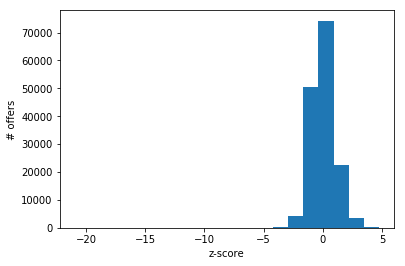

# Total Samples: 155609
zscore > 2: Classify 3.24595621076% as Dumping offers
zscore > 3: Classify 0.593795988664% as Dumping offers


In [63]:
# Histogram for all offers, based on brand-z-score
plt.hist(zscores_brand, bins=20)
plt.xlabel('z-score')
plt.ylabel('# offers')
plt.show()
print '# Total Samples: {}'.format(len(zscores_brand))
print ('zscore > 2: Classify {}% as Dumping offers'
       .format(100*float(len(zscores_brand[zscores_brand>2]))/len(zscores_brand)))
print ('zscore > 3: Classify {}% as Dumping offers'
       .format(100*float(len(zscores_brand[zscores_brand>3]))/len(zscores_brand)))

### Based on Model

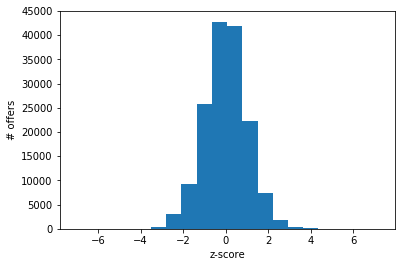

# Total Samples: 155609
zscore > 2: Classify 2.36297386398% as Dumping offers
zscore > 3: Classify 0.307822812305% as Dumping offers


In [61]:
# Histogramm for all offers, based on model-z-score
plt.hist(zscores_model, bins=20)
plt.xlabel('z-score')
plt.ylabel('# offers')
plt.show()
print '# Total Samples: {}'.format(len(zscores_model))
print ('zscore > 2: Classify {}% as Dumping offers'
       .format(100*float(len(zscores_model[zscores_model>2]))/len(zscores_model)))
print ('zscore > 3: Classify {}% as Dumping offers'
       .format(100*float(len(zscores_model[zscores_model>3]))/len(zscores_model)))

## Select the possible dumping offers, taking into account brand and model z-score

In [59]:
# Show the offers, that have a model z-score below -6 and brand z-score below -5
DUMPINGS = data[data.zscore_model>(2)]
DUMPINGS = DUMPINGS[DUMPINGS.zscore_brand>(2)]
print '\n {}% of all offers were classified as dumpings \n'.format(100*float(len(DUMPINGS))/len(data))
DUMPINGS


 1.12397097854% of all offers were classified as dumpings 



,build_id,brand,model,date_build_created,pvp_build,showroom_id,offer_id,cash_price,zscore_model,zscore_brand
5,a65ac74e-89eb-41fd-817f-956e1128289c,Peugeot,508,2018-05-23 00:48:24,30720.00000,524ce0df-be93-4592-a409-1bcf4dbe40ad,3d079109-5a61-469f-9192-bd8a34f0a38d,21016.0,2.188891,3.314665
6,a65ac74e-89eb-41fd-817f-956e1128289c,Peugeot,508,2018-05-23 00:48:24,30720.00000,cfb8a53c-543b-4f60-896e-758949863331,42fda9ec-fe25-40d2-864c-cd6980166d76,20682.0,2.393836,3.517144
9,a65ac74e-89eb-41fd-817f-956e1128289c,Peugeot,508,2018-05-23 00:48:24,30720.00000,14800a40-cacb-41f4-831c-f90ef77d1f17,a8535b35-aa14-43fa-b14f-3685a4754b34,21016.0,2.188891,3.314665
199,392c682b-14bb-417c-9e4e-0e907767154b,Citroën,C4 Spacetourer,2018-05-23 05:20:56,27350.00000,4f1fea75-46a4-4a2e-a0f4-47891656b4a2,dcdc1abb-7c73-47a5-8897-6e73f0a1cf35,19537.0,2.352952,2.115975
375,b45e4aec-9d26-49ee-adf0-6cd0c9566bc6,Suzuki,Swift,2018-05-23 06:10:09,15921.50000,13003390-61c1-4e07-82aa-3d338a16ce6e,cdf52275-a03c-4447-946c-539cd00d7519,12597.0,2.234561,2.414825
611,b8795638-7cfc-4a84-a67d-5140c9302b12,Toyota,Yaris,2018-05-23 07:15:03,15400.00000,a3c35b00-1394-4ee6-b423-2b72be4545f6,98d8ee0b-cdc1-47e1-94f5-dd8f66daaf3d,10110.0,2.799226,3.835422
733,31de4ad5-976a-420d-9398-a5050ae4d2fe,SEAT,Ibiza,2018-05-23 07:36:52,17840.00000,c7a264c9-809d-4c63-a2d9-5fcc57f8c09d,2f6a1b99-4542-43ed-9699-5c13dc0e66f1,14119.0,2.022566,2.202277
858,26d751d2-2589-40bb-a63f-0ee0a8d422b6,Dacia,Sandero,2018-05-23 07:56:40,11350.86000,df73cfa3-80f7-485e-bc40-a994922fac23,01617d63-a0e7-4666-a59d-7d10f7cd2f8a,10555.0,3.103528,3.111810
859,26d751d2-2589-40bb-a63f-0ee0a8d422b6,Dacia,Sandero,2018-05-23 07:56:40,11350.86000,5a02394e-0ea4-4ee2-ac1f-d0833bab8eb3,1fdaca49-d895-42a8-9a94-db15396d0150,10541.0,3.140438,3.151518
860,26d751d2-2589-40bb-a63f-0ee0a8d422b6,Dacia,Sandero,2018-05-23 07:56:40,11350.86000,a5e734ab-0651-4b48-9063-3e2f66355922,2f3f7d43-2096-4870-a69c-d8a9ed46aaaa,10591.0,3.008615,3.009703


## From Dumping offers, get the car-dealerships

In [67]:
dumping_dealers = np.unique(np.asarray(DUMPINGS.showroom_id))
dumping_dealers

array(['0081c4e3-d10f-47ef-8991-cafc8b1f3594',
       '0099ddb4-a791-4053-ac90-3afb10ac69fb',
       '0162762d-005e-415b-8029-23f5cf033e49',
       '02eec008-23f4-4782-931c-0cb0edc2ec89',
       '039cffef-8c96-4123-ab23-ce05e94e5cb1',
       '04178cd6-c66c-4d3f-9f04-0eb87ef0d7c5',
       '06a12443-c9f0-4e2d-9ec8-9c29eb3dd2ec',
       '073ca1ce-22e8-4f54-85a8-8ad0bf6179a9',
       '08b50b0f-28e5-4f9a-ad4d-11c7ecc6d90d',
       '08f16098-ab96-492e-b430-c526563151b7',
       '0a8711d3-a2c3-4bdb-880b-066ca7116e9b',
       '0b7b1ddd-39d5-48d7-ad22-b70a6c65ea10',
       '0ea4c2b1-a11f-4195-ab18-201a4066755f',
       '0ec2e6eb-5d98-4216-8d59-8c5320f40cf0',
       '0fd0935c-690e-4639-9153-8449f2f52262',
       '0ffb7bbd-ae0d-44dc-b20d-e7723488b303',
       '11a4fc61-ee55-474c-abda-374548b8aedf',
       '13003390-61c1-4e07-82aa-3d338a16ce6e',
       '13d9c57d-98da-4c4b-9f2a-0c0bbd410b8d',
       '14800a40-cacb-41f4-831c-f90ef77d1f17',
       '148ce575-2657-4fcb-b883-6ecea76302e6',
       '149ac